
Classificador
1. Importar dados

Para criar um classificador formatar os dados da sequinte maneira:

moleculas -> uma lista/array com todos os smiles do seu banco de dados

classes -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

O classificador vai identificar traços das moleculas e associá-los às classes, então cada molécula deverá ter o mesmo índice que sua classe.

bibliotecas sugeridas:

    pandas
    numpy



In [4]:
import pandas as pd
import numpy as np
import sklearn as sk

#Importar dados
df = pd.read_csv('/home/joao/documentos/IC-Joao/classificador/final_data_classifier.csv',index_col=False)

#Definir a coluna das classes
labels = np.asarray(df.Classe) #1 para antibiótico, 0 para não antibiótico

#Selecionar SMILES sem as classes
df_selected = df.drop(["Classe","Name","InChIKey","Index"], axis=1)

#Codificar classes (não é mais necessário)
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit(labels)

#labels = le.transform(labels)


2. Processamento dos dados
2.1 Encoding/padding

Nessa etapa acontece a codificação das moleculas. Pode ser tokens, one hot vector, integer vector. Você decide.

É importante que ao final do processamento todos os tokens tenham o mesmo comprimento, então um processo chamado padding precisa ser aplicado.

Por convenção as variáveis em machine learning assumem esses nomes:

X -> uma lista/array com todos os smiles codificados

y -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

Bibliotecas sugeridas:

    numpy
    sklearn



ADIÇÕES DO TIAGO: INICIO

In [5]:
comprimentos = [len(x) for x in df_selected.SMILES.values]


In [6]:
maior_smile = np.max(comprimentos)
maior_smile

425

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

smiles = list(df_selected.SMILES.values)

table = ['As','Cl', 'Br', 'Na', 'Li', 'Ca', 'Al', 'Ag', 'Se', 'Mg', 'Zn', 'H', 'B', 'C', 'N', 'O', 'P', 'S', 'F', 'I', 'K', '(', ')', '[', ']', '=', '#', '@', '*', '%', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '/', '\\', '+', '-', 'c', 'n', 'o', 's', 'p']


In [8]:
len(smiles)

4853

In [9]:
def tokenizer(smiles,table):
    tokens_list = []
    #index = 0
    for smile in smiles:
        #print(index)
        i = 0
        token = []
        while i < len(smile):
            for j in table:
                if j == smile[i:i+len(j)]:
                    token.append(j)
                    i = i+len(j)
                    break
        while len(token) < maior_smile:
            token.insert(0,"A")
        tokens_list.append(token)
        #index = index+1
    return tokens_list

padded_tokens = tokenizer(smiles,table)


In [10]:
len(padded_tokens)

4853

In [11]:
len(padded_tokens[0])

425

In [12]:
#Usar integer encoding ao invez de one hot
from sklearn.preprocessing import LabelEncoder
tokens_encoder = LabelEncoder()
table.append("A")
tokens_encoder.fit(table)
tokens_int_encoded = np.array([tokens_encoder.transform(i) for i in padded_tokens])


In [13]:
tokens_int_encoded

array([[21, 21, 21, ...,  3, 19, 38],
       [21, 21, 21, ..., 45, 10, 11],
       [21, 21, 21, ..., 27, 36, 10],
       ...,
       [21, 21, 21, ...,  3, 27, 27],
       [21, 21, 21, ..., 27,  3, 27],
       [21, 21, 21, ..., 27,  3, 27]])

In [14]:
tokens_int_encoded.shape

(4853, 425)

ADIÇÕES DO TIAGO: FIM


3. Holdout: train/test split

Depois do processamento, seu banco de dados precisa ser dividio em traino e teste. O Holdout é o ponto de separação. Geralmente os dados são dividos em dados em 70/30. 70% para treino e 30% para teste.

Agora as variáveis serão separadas pelos conjuntos criados:

X_treino -> 70% dos smiles codificados

X_teste -> 30% dos smiles codificados

y_treino -> 70% das classes

y_teste -> 30% das classes

Bibliotecas sugeridas:

    numpy
    sklearn



In [184]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, labels_train, labels_test = train_test_split(
    tokens_int_encoded, labels, 
    test_size=0.30, random_state=42)



4. Modelo

Depois de preparar os dados, precisamos criar um variável que contem nosso modelo. Estude o tensoflow/keras, mais especificamente a função Sequential(), para criação dos modelos.

Arquiteturas sugeridas:

    MultiLayer Perceptron (MLP)
    Convolutional Neural Networks (CNN)

Não esqueça de adicionar as métricas precision, recall, accuracy e loss. Para essa ultima, você precisa estudar sobre as funções de perda usadas para classificação binária (0,1).

Depois de construído use o método .fit() para treinar seu classificador


In [185]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential([
    tf.keras.layers.Input(shape = 425,),
    tf.keras.layers.Dense(300, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(
    optimizer='adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = [tf.metrics.BinaryAccuracy(),
    tf.metrics.Precision(),
    tf.metrics.Recall()]

)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 425)               181050    
                                                                 
 dense_4 (Dense)             (None, 100)               42600     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 223,751
Trainable params: 223,751
Non-trainable params: 0
_________________________________________________________________


In [186]:
MLP = model.fit(smiles_train,labels_train, epochs=100, verbose =1,validation_data=(smiles_test,labels_test))

Epoch 1/100
107/107 [==============================] - 1s 3ms/step - loss: 1.3212 - binary_accuracy: 0.8419 - precision_14: 0.1472 - recall_14: 0.1350 - val_loss: 0.4192 - val_binary_accuracy: 0.8482 - val_precision_14: 0.3280 - val_recall_14: 0.3974
Epoch 2/100
107/107 [==============================] - 0s 1ms/step - loss: 0.5099 - binary_accuracy: 0.8731 - precision_14: 0.2892 - recall_14: 0.2209 - val_loss: 0.5127 - val_binary_accuracy: 0.8977 - val_precision_14: 0.8182 - val_recall_14: 0.0577
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 0.4116 - binary_accuracy: 0.8849 - precision_14: 0.3556 - recall_14: 0.2454 - val_loss: 0.4037 - val_binary_accuracy: 0.8393 - val_precision_14: 0.3347 - val_recall_14: 0.5064
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 0.4251 - binary_accuracy: 0.8878 - precision_14: 0.3767 - recall_14: 0.2577 - val_loss: 0.2807 - val_binary_accuracy: 0.9155 - val_precision_14: 0.7538 - val_recall_14: 0.3

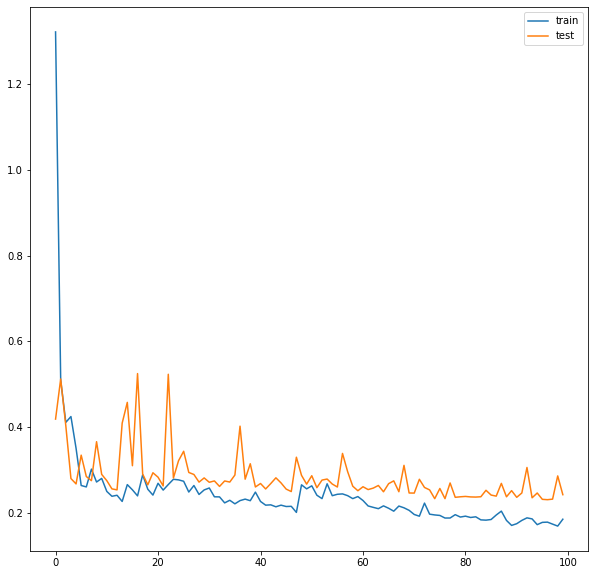

In [187]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(MLP.history['loss'],label = 'train')
plt.plot(MLP.history['val_loss'],label = 'test')
plt.legend()


In [188]:
predictions = np.round(model.predict(smiles_test))

In [189]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predictions)

In [69]:
import seaborn as sns


Text(0.5, 15.0, 'PREDICTED')

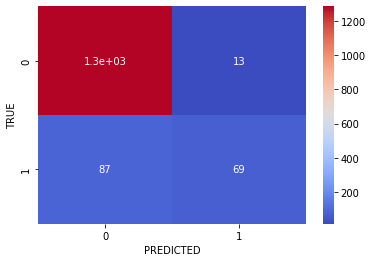

In [190]:
sns.heatmap(cm, annot=True,cmap='coolwarm')
plt.ylabel("TRUE")
plt.xlabel("PREDICTED")

In [191]:
tn, fp, fn, tp = confusion_matrix(labels_test, predictions).ravel()

In [192]:
tn, fp, fn, tp 

(1287, 13, 87, 69)

In [193]:
#acurácia
(tp+tn)/(tp+tn+fp+fn)

0.9313186813186813

In [194]:
#acerta o que é antibiótico
(tp)/(tp+fn)

0.4423076923076923

In [183]:
#acerta o que não é antibiótico
(tn)/(tn+fp)

0.9907321594068582